In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
from loader import load_models, MODEL_ORDER, MODEL_COLORS, PANEL_DATA_PATH

# Only load columns needed for context slicing
usecols = ["game_id", "experiment", "player_id", "civilization", "max_turn", "is_winner", "predicted_win_probability", "turn_progress"]
models = load_models(usecols=usecols)

# Filter to late-game only
for name in models:
    models[name] = models[name][models[name]['turn_progress'] > 0.8]
    print(f"  Filtered {name}: {len(models[name]):,} rows (turn_progress > 0.8)")

print(f"\nModels found: {list(models.keys())}")

Loaded naive: 1,875,256 rows
Loaded score: 1,875,256 rows
Loaded baseline: 1,875,256 rows
Loaded xgboost: 1,875,256 rows
Loaded mlp: 1,875,256 rows
Loaded grouped_mlp: 1,875,256 rows
Loaded interaction_mlp: 1,875,256 rows
Loaded attention_mlp: 1,875,256 rows
  Filtered naive: 376,712 rows (turn_progress > 0.8)
  Filtered score: 376,712 rows (turn_progress > 0.8)
  Filtered baseline: 376,712 rows (turn_progress > 0.8)
  Filtered xgboost: 376,712 rows (turn_progress > 0.8)
  Filtered mlp: 376,712 rows (turn_progress > 0.8)
  Filtered grouped_mlp: 376,712 rows (turn_progress > 0.8)
  Filtered interaction_mlp: 376,712 rows (turn_progress > 0.8)
  Filtered attention_mlp: 376,712 rows (turn_progress > 0.8)

Models found: ['naive', 'score', 'baseline', 'xgboost', 'mlp', 'grouped_mlp', 'interaction_mlp', 'attention_mlp']


## 3a. Log Loss by Experiment
Heatmap showing how each model performs across different AI matchup experiments.

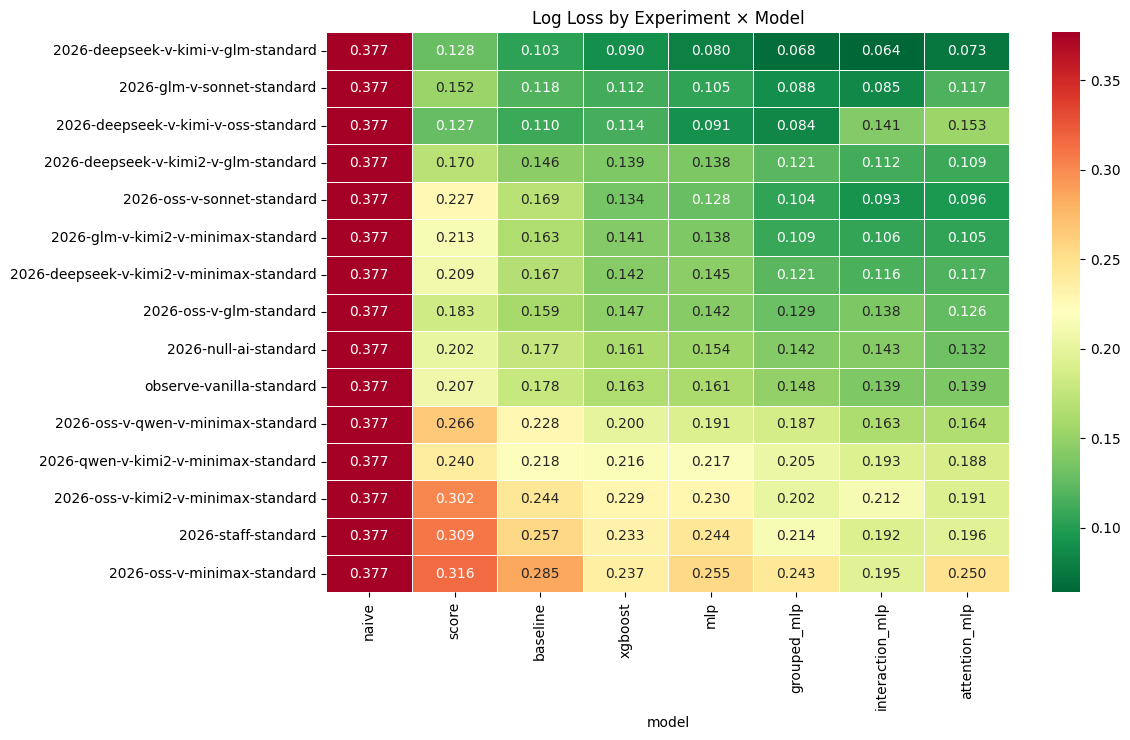

In [2]:
rows_list = []
for name, df in models.items():
    for exp, grp in df.groupby("experiment"):
        ll = log_loss(grp["is_winner"], grp["predicted_win_probability"], labels=[0, 1])
        rows_list.append({"model": name, "experiment": exp, "log_loss": ll})

exp_df = pd.DataFrame(rows_list)
pivot = exp_df.pivot(index="experiment", columns="model", values="log_loss")
pivot = pivot[MODEL_ORDER]

# Sort experiments by mean log loss across models
pivot = pivot.loc[pivot.mean(axis=1).sort_values().index]

fig, ax = plt.subplots(figsize=(max(8, len(MODEL_ORDER) * 1.5), max(6, len(pivot) * 0.5)))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="RdYlGn_r", ax=ax, linewidths=0.5)
ax.set_title("Log Loss by Experiment × Model")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

## 3b. Log Loss by Civilization
Shows which civilizations are hardest/easiest to predict across models.

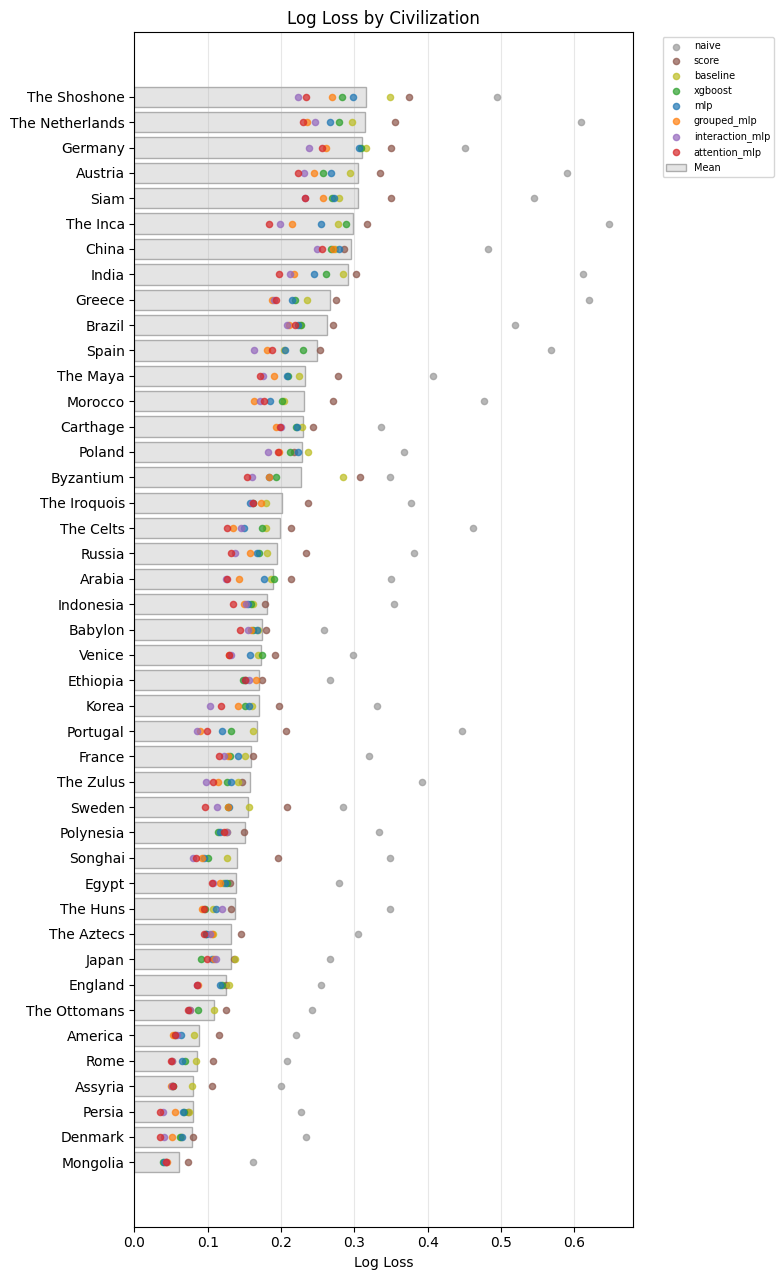

In [3]:
rows_list = []
for name, df in models.items():
    for civ, grp in df.groupby("civilization"):
        if len(grp) < 100:  # skip tiny samples
            continue
        ll = log_loss(grp["is_winner"], grp["predicted_win_probability"], labels=[0, 1])
        rows_list.append({"model": name, "civilization": civ, "log_loss": ll, "n": len(grp)})

civ_df = pd.DataFrame(rows_list)

# Average across models for sorting
civ_avg = civ_df.groupby("civilization")["log_loss"].mean().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, max(6, len(civ_avg) * 0.3)))

# Plot each model as a point, with mean as a bar
civ_order = civ_avg.index.tolist()
ax.barh(civ_order, civ_avg.values, color="lightgray", edgecolor="gray", alpha=0.6, label="Mean")

for name in MODEL_ORDER:
    sub = civ_df[civ_df["model"] == name].set_index("civilization").reindex(civ_order)
    ax.scatter(sub["log_loss"], sub.index, s=20, alpha=0.7, label=name, zorder=3, color=MODEL_COLORS[name])

ax.set_xlabel("Log Loss")
ax.set_title("Log Loss by Civilization")
ax.legend(fontsize=7, bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

## 3c. Log Loss by Game Length
Are short or long games harder to predict?

Game length quartiles: ['0-397', '397-427', '427-451', '451-501']
Bin edges: [  0. 397. 427. 451. 501.]


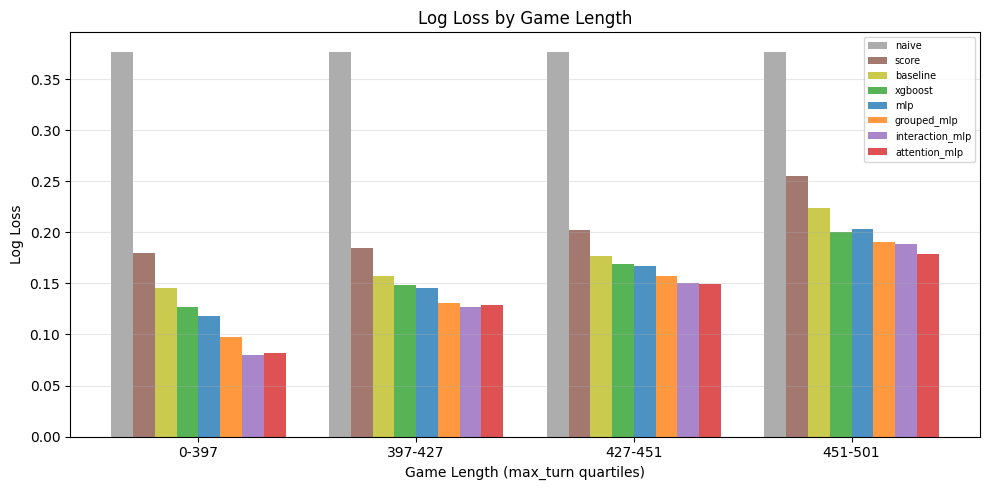

In [4]:
# Use the first available model to get game length quartiles
ref_df = models[MODEL_ORDER[0]]
game_lengths = ref_df.groupby("game_id")["max_turn"].first()
quartile_bins = game_lengths.quantile([0, 0.25, 0.5, 0.75, 1.0]).values
quartile_bins[0] = 0  # ensure lower bound captures all
quartile_bins[-1] += 1  # ensure upper bound captures all
quartile_labels = [f"{int(quartile_bins[i])}-{int(quartile_bins[i+1])}" for i in range(len(quartile_bins) - 1)]

print(f"Game length quartiles: {quartile_labels}")
print(f"Bin edges: {quartile_bins}")

rows_list = []
for name, df in models.items():
    df = df.copy()
    df["length_bin"] = pd.cut(df["max_turn"], bins=quartile_bins, labels=quartile_labels, right=False)
    for bin_label, grp in df.groupby("length_bin", observed=True):
        ll = log_loss(grp["is_winner"], grp["predicted_win_probability"], labels=[0, 1])
        rows_list.append({"model": name, "length_bin": bin_label, "log_loss": ll, "n_games": grp["game_id"].nunique()})

length_df = pd.DataFrame(rows_list)

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(quartile_labels))
width = 0.8 / len(MODEL_ORDER)

for i, name in enumerate(MODEL_ORDER):
    sub = length_df[length_df["model"] == name].set_index("length_bin").reindex(quartile_labels)
    ax.bar(x + i * width, sub["log_loss"], width, label=name, alpha=0.8, color=MODEL_COLORS[name])

ax.set_xticks(x + width * (len(MODEL_ORDER) - 1) / 2)
ax.set_xticklabels(quartile_labels)
ax.set_xlabel("Game Length (max_turn quartiles)")
ax.set_ylabel("Log Loss")
ax.set_title("Log Loss by Game Length")
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

## 3d. Log Loss by Victory Type
How well does each model predict games that end in different victory conditions?

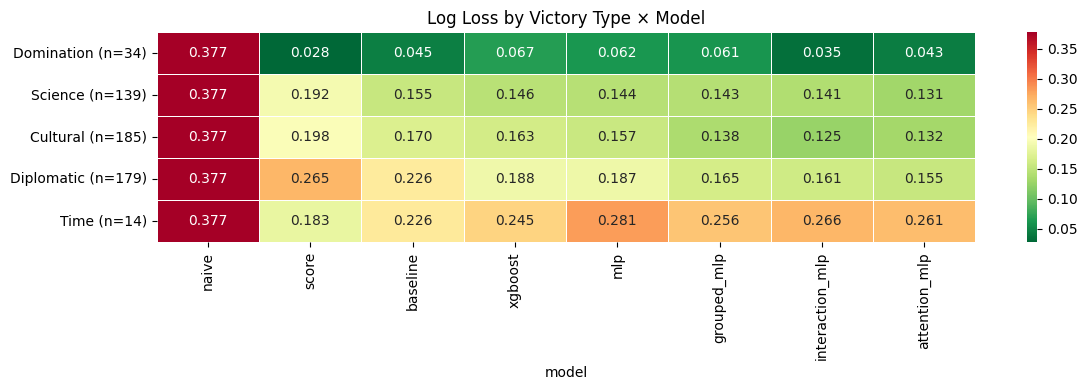

In [5]:
# Load victory_type from panel_data and join to predictions
panel_victory = pd.read_csv(PANEL_DATA_PATH, usecols=["game_id", "victory_type"])
panel_victory = panel_victory.drop_duplicates(subset="game_id")

rows_list = []
for name, df in models.items():
    df_v = df.merge(panel_victory, on="game_id", how="left")
    for vtype, grp in df_v.groupby("victory_type"):
        ll = log_loss(grp["is_winner"], grp["predicted_win_probability"], labels=[0, 1])
        rows_list.append({"model": name, "victory_type": vtype, "log_loss": ll, "n_games": grp["game_id"].nunique()})

vtype_df = pd.DataFrame(rows_list)
pivot = vtype_df.pivot(index="victory_type", columns="model", values="log_loss")
pivot = pivot[MODEL_ORDER]

# Sort by mean log loss
pivot = pivot.loc[pivot.mean(axis=1).sort_values().index]

fig, ax = plt.subplots(figsize=(max(8, len(MODEL_ORDER) * 1.5), max(4, len(pivot) * 0.8)))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="RdYlGn_r", ax=ax, linewidths=0.5)
ax.set_title("Log Loss by Victory Type × Model")
ax.set_ylabel("")

# Add game counts as row labels
n_games = vtype_df.groupby("victory_type")["n_games"].first().reindex(pivot.index)
ax.set_yticklabels([f"{vt} (n={n_games[vt]:,})" for vt in pivot.index], rotation=0)

plt.tight_layout()
plt.show()

## 3e. Log Loss by Player Type
How well does each model predict outcomes for different AI player types (e.g., Vanilla, GPT-OSS-120B-Simple, Sonnet-4.5-Briefed)?

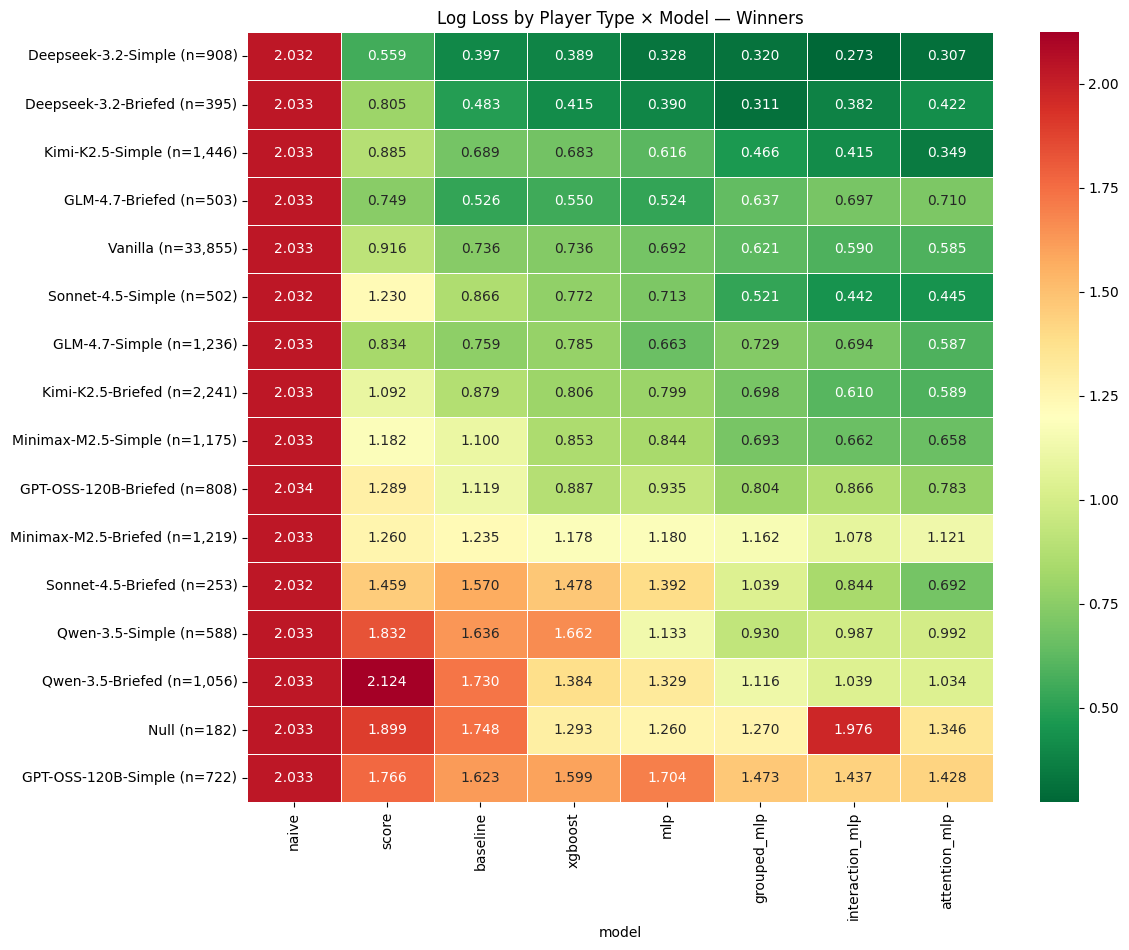

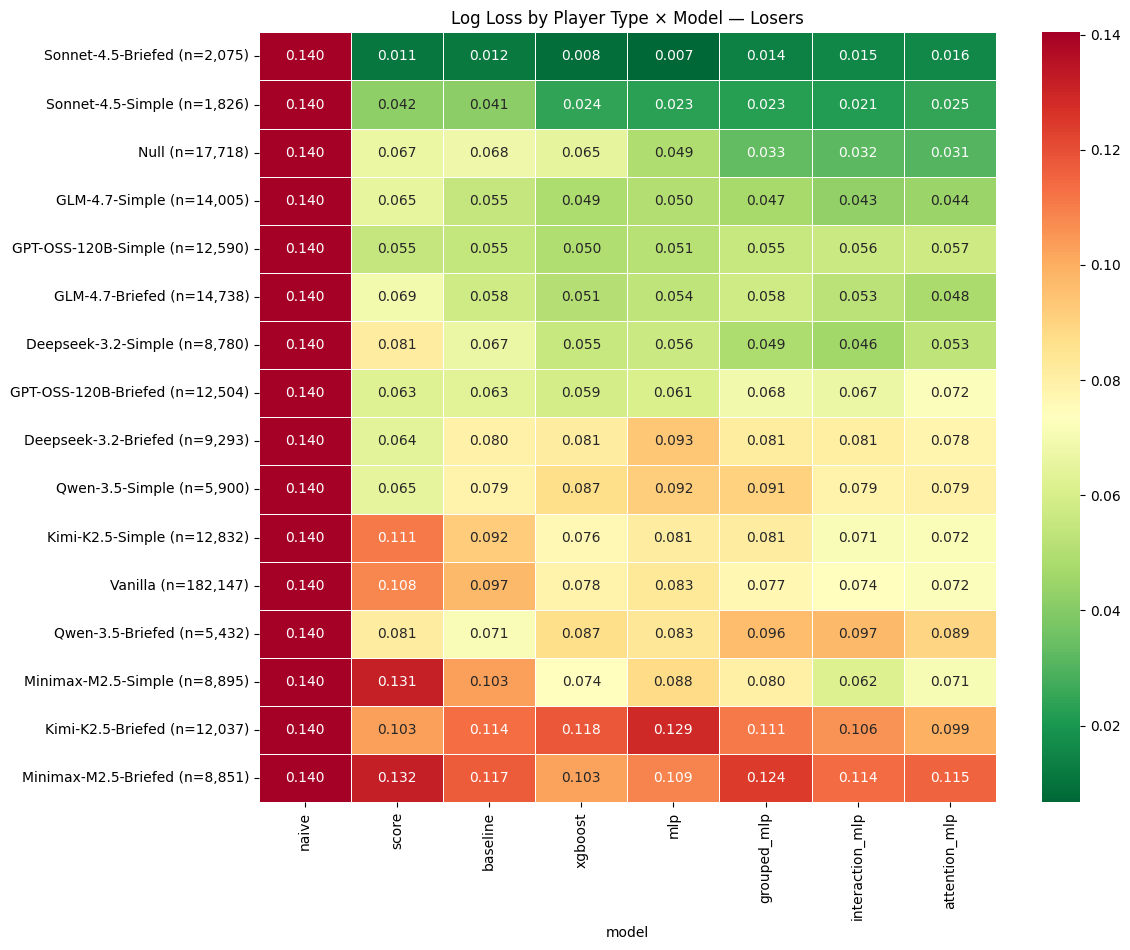

In [6]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))
from plot_utilities import CONDITION_PLAYER_MAPPING

def add_player_type(df):
    """Map experiment + player_id -> player_type using CONDITION_PLAYER_MAPPING."""
    mapping_rows = []
    for condition, player_types in CONDITION_PLAYER_MAPPING.items():
        for pid, ptype in enumerate(player_types):
            mapping_rows.append({"experiment": condition, "player_id": pid, "player_type": ptype})
    mapping_df = pd.DataFrame(mapping_rows)
    return df.merge(mapping_df, on=["experiment", "player_id"], how="left")

for label, outcome in [("Winners", 1), ("Losers", 0)]:
    rows_list = []
    for name, df in models.items():
        df_pt = add_player_type(df[df["is_winner"] == outcome])
        df_pt = df_pt.dropna(subset=["player_type"])
        for ptype, grp in df_pt.groupby("player_type"):
            if len(grp) < 100:
                continue
            ll = log_loss(grp["is_winner"], grp["predicted_win_probability"], labels=[0, 1])
            rows_list.append({"model": name, "player_type": ptype, "log_loss": ll, "n": len(grp)})

    pt_df = pd.DataFrame(rows_list)
    pivot = pt_df.pivot(index="player_type", columns="model", values="log_loss")
    pivot = pivot[MODEL_ORDER]
    pivot = pivot.loc[pivot.mean(axis=1).sort_values().index]

    fig, ax = plt.subplots(figsize=(max(8, len(MODEL_ORDER) * 1.5), max(4, len(pivot) * 0.6)))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="RdYlGn_r", ax=ax, linewidths=0.5)
    ax.set_title(f"Log Loss by Player Type × Model — {label}")
    ax.set_ylabel("")

    n_counts = pt_df.groupby("player_type")["n"].first().reindex(pivot.index)
    ax.set_yticklabels([f"{pt} (n={n_counts[pt]:,})" for pt in pivot.index], rotation=0)

    plt.tight_layout()
    plt.show()